In [193]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import torch 
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader


# from lifelines import KaplanMeierFitter
import seaborn as sns
import matplotlib.pyplot as plt

In [194]:
data = pd.read_csv('./Tree_Data.csv')

print(data.head())

     No  Plot Subplot         Species  Light_ISF Light_Cat  Core  \
0   126     1       C  Acer saccharum       0.11       Med  2017   
1    11     1       C    Quercus alba       0.11       Med  2017   
2    12     1       C   Quercus rubra       0.11       Med  2017   
3  2823     7       D  Acer saccharum       0.08       Med  2016   
4  5679    14       A  Acer saccharum       0.06       Low  2017   

              Soil Adult      Sterile  ...   AMF   EMF Phenolics Lignin   NSC  \
0  Prunus serotina     I  Non-Sterile  ... 22.00   NaN     -0.56  13.86 12.15   
1    Quercus rubra   970  Non-Sterile  ... 15.82 31.07      5.19  20.52 19.29   
2  Prunus serotina     J  Non-Sterile  ... 24.45 28.19      3.36  24.74 15.01   
3  Prunus serotina     J  Non-Sterile  ... 22.23   NaN     -0.71  14.29 12.36   
4  Prunus serotina   689  Non-Sterile  ... 21.15   NaN     -0.58  10.85 11.20   

   Census   Time  Event  Harvest  Alive  
0       4  14.00   1.00      NaN    NaN  
1      33 115.50   0

In [195]:
data.shape

(2783, 24)

In [196]:
# Checking for null values
print(data.isnull().sum())

No              0
Plot            0
Subplot         0
Species         0
Light_ISF       0
             ... 
Census          0
Time            0
Event           1
Harvest      2079
Alive        2292
Length: 24, dtype: int64


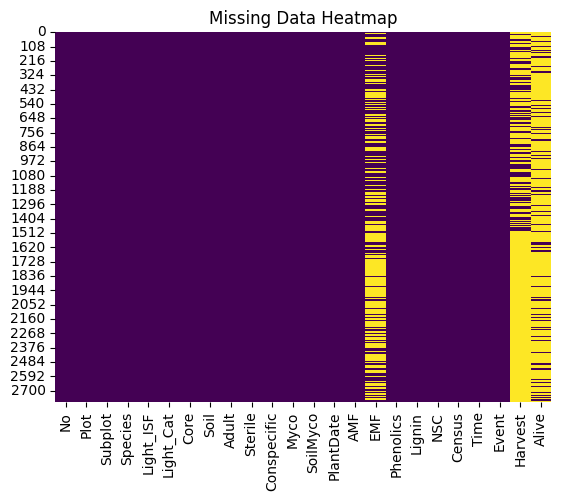

In [197]:
# Visualizing missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [198]:
# Impute Event with the mode
data['Event'].fillna(data['Event'].mode()[0], inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_10828\3862981972.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Event'].fillna(data['Event'].mode()[0], inplace=True)


In [199]:
# Impute EMF with the mean
data['EMF'].fillna(data['EMF'].mean(), inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_10828\1828988850.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['EMF'].fillna(data['EMF'].mean(), inplace=True)


In [200]:
# Drop columns with high missing data
data.drop(columns=['Harvest', 'Alive'], inplace=True)

In [201]:
print(data.isnull().sum())

No           0
Plot         0
Subplot      0
Species      0
Light_ISF    0
            ..
Lignin       0
NSC          0
Census       0
Time         0
Event        0
Length: 22, dtype: int64


In [202]:
data.shape

(2783, 22)

In [203]:
data

,No,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Adult,Sterile,...,SoilMyco,PlantDate,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event
0,126,1,C,Acer saccharum,0.11,Med,2017,Prunus serotina,I,Non-Sterile,...,AMF,6/11/18,22.00,26.48,-0.56,13.86,12.15,4,14.00,1.00
1,11,1,C,Quercus alba,0.11,Med,2017,Quercus rubra,970,Non-Sterile,...,EMF,5/25/18,15.82,31.07,5.19,20.52,19.29,33,115.50,0.00
2,12,1,C,Quercus rubra,0.11,Med,2017,Prunus serotina,J,Non-Sterile,...,AMF,5/31/18,24.45,28.19,3.36,24.74,15.01,18,63.00,1.00
3,2823,7,D,Acer saccharum,0.08,Med,2016,Prunus serotina,J,Non-Sterile,...,AMF,6/11/18,22.23,26.48,-0.71,14.29,12.36,4,14.00,1.00
4,5679,14,A,Acer saccharum,0.06,Low,2017,Prunus serotina,689,Non-Sterile,...,AMF,6/11/18,21.15,26.48,-0.58,10.85,11.20,4,14.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,7165,17,B,Prunus serotina,0.11,Med,2017,Populus grandidentata,891,Non-Sterile,...,EMF,6/7/18,40.89,26.48,0.83,9.15,11.88,16,56.00,1.00
2779,7217,17,D,Quercus alba,0.12,Med,2017,Acer rubrum,1468,Non-Sterile,...,AMF,5/25/18,15.47,32.82,4.88,19.01,23.50,16,56.00,1.00
2780,7306,17,D,Quercus alba,0.12,Med,2017,Quercus rubra,1454,Non-Sterile,...,EMF,5/25/18,11.96,37.67,5.51,21.13,19.10,16,56.00,1.00
2781,7771,18,D,Quercus alba,0.16,High,2017,Sterile,1297,Sterile,...,Sterile,5/17/18,16.99,22.51,4.28,19.38,21.36,33,115.50,1.00


In [204]:
# Select relevant features for clustering
features = ['AMF', 'EMF', 'Phenolics', 'Lignin', 'NSC', 'Light_ISF']
X = data[features]
X.shape

(2783, 6)

In [205]:
# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

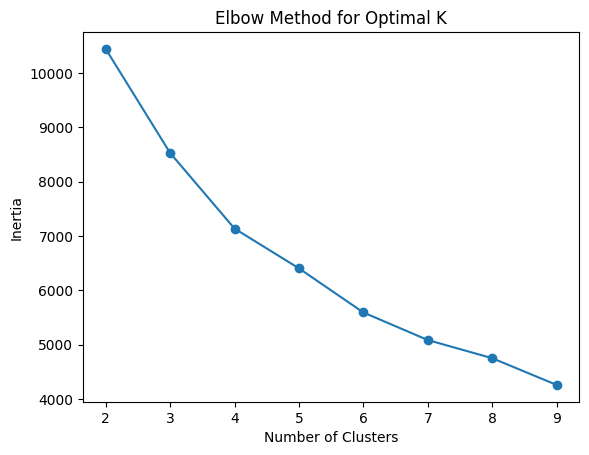

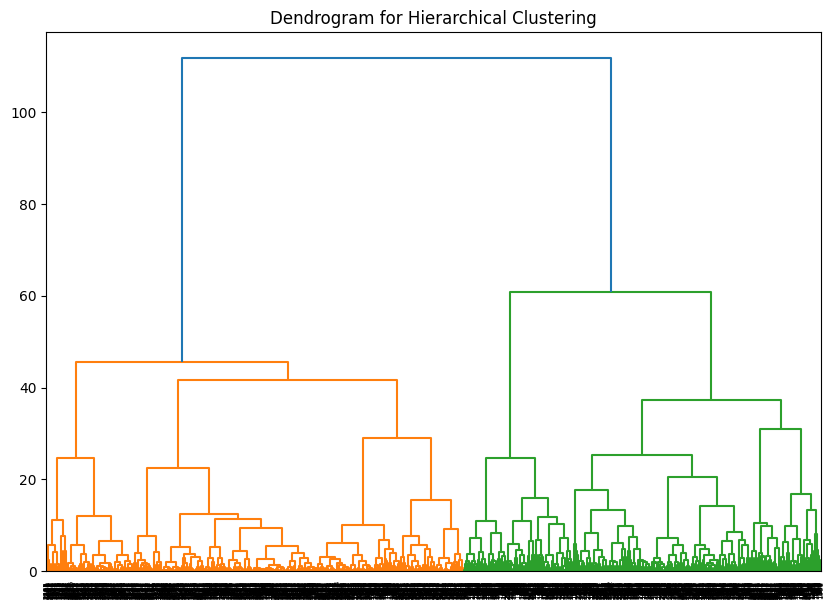

In [206]:
# K-Means Clustering
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Elbow method visualization
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Hierarchical Clustering
linkage_matrix = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

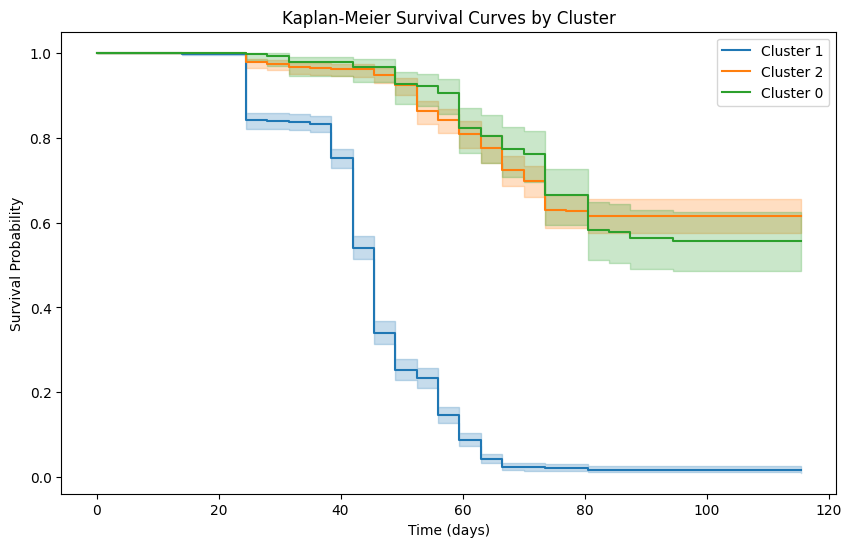

In [207]:
from lifelines import KaplanMeierFitter

# Assign cluster labels
optimal_k = 3  # Example value from elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    kmf.fit(durations=cluster_data['Time'], event_observed=cluster_data['Event'], label=f'Cluster {cluster}')
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Cluster')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [208]:
features = ['AMF', 'EMF', 'Phenolics', 'Lignin', 'NSC', 'Light_ISF']
X = data[features]
Y = data['Event'] 

In [209]:
X

,AMF,EMF,Phenolics,Lignin,NSC,Light_ISF
0,22.00,26.48,-0.56,13.86,12.15,0.11
1,15.82,31.07,5.19,20.52,19.29,0.11
2,24.45,28.19,3.36,24.74,15.01,0.11
3,22.23,26.48,-0.71,14.29,12.36,0.08
4,21.15,26.48,-0.58,10.85,11.20,0.06
...,...,...,...,...,...,...
2778,40.89,26.48,0.83,9.15,11.88,0.11
2779,15.47,32.82,4.88,19.01,23.50,0.12
2780,11.96,37.67,5.51,21.13,19.10,0.12
2781,16.99,22.51,4.28,19.38,21.36,0.16


In [210]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [211]:
class TreeSurvivalDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [212]:
# Create Datasets
train_dataset = TreeSurvivalDataset(X_train, Y_train)
test_dataset = TreeSurvivalDataset(X_test, Y_test)
dev_dataset = TreeSurvivalDataset(X_dev, Y_dev)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)


In [213]:
# Create datasets
train_dataset = TreeSurvivalDataset(X_train, Y_train)
test_dataset = TreeSurvivalDataset(X_test, Y_test)
dev_dataset = TreeSurvivalDataset(X_dev, Y_dev)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [214]:
# Define the neural network
class TreeSurvivalNN(NN.Module):
    def __init__(self, input_size):
        super(TreeSurvivalNN, self).__init__()
        self.model = NN.Sequential(
        NN.Linear(input_size, 64),
        NN.ReLU(),
        NN.Dropout(0.3),          
        NN.Linear(64, 1),
        NN.Sigmoid()
)

    def forward(self, x):
        return self.model(x)

In [215]:

# Instantiate the model
input_size = X_train.shape[1]
model = TreeSurvivalNN(input_size)


In [216]:
import torch.optim as optim

# Loss function and optimizer
criterion = NN.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [217]:
num_epochs = 50
best_dev_loss = float('inf')  # For early stopping

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(batch_features).squeeze()  # Forward pass
        loss = criterion(outputs, batch_labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    dev_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_labels in dev_loader:
            outputs = model(batch_features).squeeze()
            loss = criterion(outputs, batch_labels)
            dev_loss += loss.item()

    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Dev Loss: {dev_loss/len(dev_loader):.4f}")

    # Save the best model
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), "best_tree_survival_model.pth")


Epoch 1/50, Train Loss: 0.9630, Dev Loss: 0.5333
Epoch 2/50, Train Loss: 0.6874, Dev Loss: 0.5102
Epoch 3/50, Train Loss: 0.5965, Dev Loss: 0.4907
Epoch 4/50, Train Loss: 0.5503, Dev Loss: 0.4824
Epoch 5/50, Train Loss: 0.5264, Dev Loss: 0.4745
Epoch 6/50, Train Loss: 0.5052, Dev Loss: 0.4572
Epoch 7/50, Train Loss: 0.5016, Dev Loss: 0.4504
Epoch 8/50, Train Loss: 0.4991, Dev Loss: 0.4551
Epoch 9/50, Train Loss: 0.4849, Dev Loss: 0.4569
Epoch 10/50, Train Loss: 0.4821, Dev Loss: 0.4458
Epoch 11/50, Train Loss: 0.4791, Dev Loss: 0.4297
Epoch 12/50, Train Loss: 0.4803, Dev Loss: 0.4345
Epoch 13/50, Train Loss: 0.4713, Dev Loss: 0.4206
Epoch 14/50, Train Loss: 0.4693, Dev Loss: 0.4133
Epoch 15/50, Train Loss: 0.4621, Dev Loss: 0.4196
Epoch 16/50, Train Loss: 0.4621, Dev Loss: 0.4137
Epoch 17/50, Train Loss: 0.4617, Dev Loss: 0.4084
Epoch 18/50, Train Loss: 0.4622, Dev Loss: 0.4134
Epoch 19/50, Train Loss: 0.4599, Dev Loss: 0.4203
Epoch 20/50, Train Loss: 0.4583, Dev Loss: 0.4061
Epoch 21/

In [218]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Load the best model
model.load_state_dict(torch.load("best_tree_survival_model.pth"))
model.eval()

# Evaluate on test data
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features).squeeze()
        y_pred = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        y_pred_list.extend(y_pred.tolist())
        y_true_list.extend(batch_labels.tolist())

# Calculate metrics
accuracy = accuracy_score(y_true_list, y_pred_list)
precision = precision_score(y_true_list, y_pred_list)
recall = recall_score(y_true_list, y_pred_list)
conf_matrix = confusion_matrix(y_true_list, y_pred_list)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8381
Precision: 0.9103
Recall: 0.8049
Confusion Matrix:
[[101  13]
 [ 32 132]]


C:\Users\PMLS\AppData\Local\Temp\ipykernel_10828\1053174123.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_tree_survival_model.pt

In [219]:
# Example new data point
# features = ['AMF', 'EMF', 'Phenolics', 'Lignin', 'NSC', 'Light_ISF']
new_data = [[39.02, 26.48, -1.20, 8.78, 9.56, 0.047]]

new_data_scaled = scaler.transform(new_data)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)

# Make prediction
model.eval()
with torch.no_grad():
    prediction = model(new_data_tensor).item()  # Get the probability (sigmoid output)
    predicted_class = 1 if prediction >= 0.5 else 0  # Apply threshold
    print(f"Predicted Probability: {prediction:.4f}")
    print(f"Predicted Class: {predicted_class}")

Predicted Probability: 0.8109
Predicted Class: 1


C:\Users\PMLS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [220]:
# Assign cluster
cluster_label = kmeans.predict(new_data_scaled)[0]
print(f"Assigned Cluster: {cluster_label}")

Assigned Cluster: 1


In [221]:
# Kaplan-Meier survival analysis
cluster_data = data[data['Cluster'] == cluster_label]
kmf = KaplanMeierFitter()
kmf.fit(durations=cluster_data['Time'], event_observed=cluster_data['Event'])

# Median survival time
median_survival_time = kmf.median_survival_time_
print(f"Estimated Median Survival Time for Cluster {cluster_label}: {median_survival_time} days")


Estimated Median Survival Time for Cluster 1: 45.5 days


In [222]:
# Predict survival probability
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)
model.eval()
with torch.no_grad():
    survival_probability = model(new_data_tensor).item()
    predicted_class = 1 if survival_probability >= 0.5 else 0

print(f"Predicted Survival Probability: {survival_probability:.4f}")
print(f"Predicted Class (0 = Alive, 1 = Dead): {predicted_class}")
print(f"Estimated Median Survival Time: {median_survival_time} days")

Predicted Survival Probability: 0.8109
Predicted Class (0 = Alive, 1 = Dead): 1
Estimated Median Survival Time: 45.5 days


In [223]:
def estimate_survival_time(model, scaler, kmeans, kmfs, new_data):
    """
    Predict survival probability and estimate survival time.

    Args:
        model: Trained PyTorch model.
        scaler: Fitted StandardScaler for feature normalization.
        kmeans: Trained KMeans clustering model.
        kmfs: Dictionary of Kaplan-Meier fitters, one per cluster.
        new_data: List of feature values for the new tree.

    Returns:
        survival_probability: Predicted survival probability (0-1).
        predicted_class: Predicted class (0 = alive, 1 = dead).
        median_survival_time: Estimated median survival time in days.
    """
    # Preprocess new data
    new_data_scaled = scaler.transform([new_data])

    # Assign cluster
    cluster_label = kmeans.predict(new_data_scaled)[0]

    # Retrieve Kaplan-Meier fitter for the cluster
    kmf = kmfs[cluster_label]
    median_survival_time = kmf.median_survival_time_

    # Predict survival probability
    new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        survival_probability = model(new_data_tensor).item()
        predicted_class = 1 if survival_probability >= 0.5 else 0

    return survival_probability, predicted_class, median_survival_time

# Example usage
kmfs = {}
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    kmf = KaplanMeierFitter()
    kmf.fit(durations=cluster_data['Time'], event_observed=cluster_data['Event'])
    kmfs[cluster] = kmf

new_tree = [39.02, 26.48, -1.20, 8.78, 9.56, 0.047]
probability, predicted_class, survival_time = estimate_survival_time(model, scaler, kmeans, kmfs, new_tree)

print(f"Survival Probability: {probability:.4f}")
print(f"Predicted Class: {'Dead' if predicted_class == 1 else 'Alive'}")
print(f"Estimated Median Survival Time: {survival_time} days")


Survival Probability: 0.8109
Predicted Class: Dead
Estimated Median Survival Time: 45.5 days


C:\Users\PMLS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


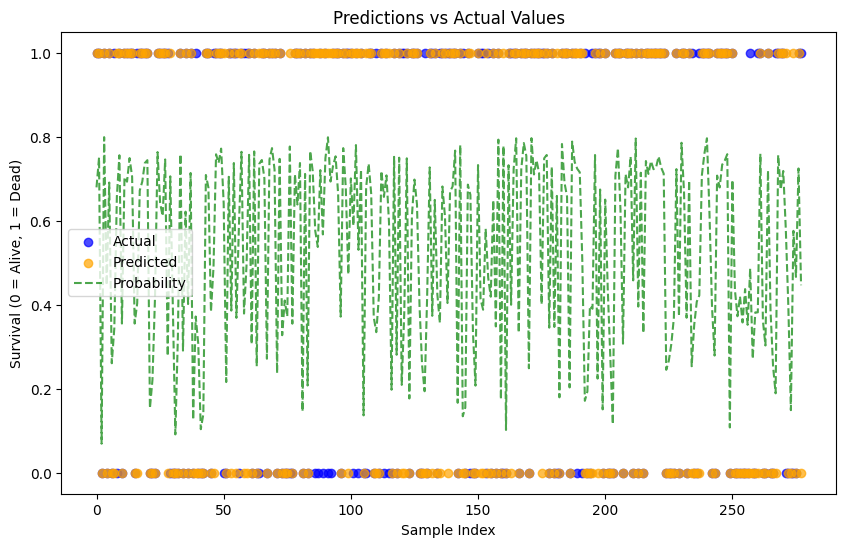

In [224]:
import matplotlib.pyplot as plt
import torch

# Function to predict survival probabilities and classes for the test set
def test_model_on_data(model, scaler, X_test, Y_test):
    # Preprocess test data
    X_test_scaled = scaler.transform(X_test)  # Scale the features
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # Generate predictions
    model.eval()
    with torch.no_grad():
        probabilities = model(X_test_tensor).squeeze().numpy()  # Get probabilities
        predictions = (probabilities >= 0.5).astype(int)        # Convert to binary predictions

    return probabilities, predictions

# Generate predictions on X_test
probabilities, predictions = test_model_on_data(model, scaler, X_test, Y_test)

# Convert Y_test to a NumPy array for comparison
Y_test_array = Y_test.to_numpy()

# Visualize predictions vs actual labels
plt.figure(figsize=(10, 6))

# Plot true values
plt.scatter(range(len(Y_test_array)), Y_test_array, label='Actual', alpha=0.7, color='blue')

# Plot predictions
plt.scatter(range(len(predictions)), predictions, label='Predicted', alpha=0.7, color='orange')

# Add a line for probabilities (optional, for continuous output visualization)
plt.plot(range(len(probabilities)), probabilities, label='Probability', color='green', linestyle='--', alpha=0.7)

# Customize plot
plt.title('Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Survival (0 = Alive, 1 = Dead)')
plt.legend()
plt.show()


In [227]:
# Recalculate probabilities of death
probability_of_death = 1 - probabilities  # Probability of tree being dead

# Recalculate predictions based on death probability
predictions_corrected = (probability_of_death >= 0.5).astype(int)

# Create a DataFrame to compare results
results_df = pd.DataFrame({
    'Sample Index': range(len(Y_test)),
    'Actual Label': Y_test.to_numpy(),                     # Actual labels
    'Predicted Label': predictions_corrected,              # Updated predictions
    'Survival Probability': probabilities,                 # Survival probability
    'Probability of Death': probability_of_death           # Corrected death probability
})

# Add a column to identify misclassifications
results_df['Correct Prediction'] = results_df['Actual Label'] == results_df['Predicted Label']

# Display the table
pd.set_option('display.max_rows', 20)  # Limit rows to display (adjust as needed)
pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats for readability
print(results_df)

# Summarize the results
summary = results_df['Correct Prediction'].value_counts()
print("\nSummary:")
print(f"Total Samples: {len(Y_test)}")
print(f"Correct Predictions: {summary[True]}")
print(f"Incorrect Predictions: {summary[False]}")


     Sample Index  Actual Label  Predicted Label  Survival Probability  \
0               0          1.00                0                  0.68   
1               1          1.00                0                  0.75   
2               2          0.00                1                  0.07   
3               3          1.00                0                  0.80   
4               4          0.00                1                  0.45   
..            ...           ...              ...                   ...   
273           273          0.00                1                  0.15   
274           274          0.00                0                  0.58   
275           275          0.00                1                  0.47   
276           276          1.00                0                  0.72   
277           277          1.00                1                  0.45   

     Probability of Death  Correct Prediction  
0                    0.32               False  
1              